In [1]:
# fit_many_transects - Loop through transects and collect fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LinearRegression, RANSACRegressor, TheilSenRegressor
from scipy import stats
import statsmodels.api as sm
import pymc as pm
from scipy.optimize import curve_fit

In [2]:
data_dir = 'C:/crs/proj/2025_shoreline_fits/'
#fn = 'Northshore_LT_intersects.csv'
fn = 'OuterCapeE_intersects_LT.csv'
df = pd.read_csv(data_dir+fn)

# Convert to datetime format
df["date"] = pd.to_datetime(df["ShorelineI"], format="%m/%d/%Y")

# Function to convert datetime to decimal year
def datetime_to_decimal_year(dt):
    year = dt.year
    start_of_year = pd.Timestamp(f"{year}-01-01")
    end_of_year = pd.Timestamp(f"{year+1}-01-01")
    decimal_year = year + (dt - start_of_year).total_seconds() / (end_of_year - start_of_year).total_seconds()
    return decimal_year

# Apply function to convert each date
df["decimal_year"] = df["date"].apply(datetime_to_decimal_year)
df

,<Feature Name>,<Feature Type>,TransectID,TransOrder,BaselineID,ShorelineI,Distance,IntersectX,IntersectY,Uncertaint,...,BIAS,BIAS_X,BIAS_Y,Bias_Uncer,<Feature Description>,<Feature Layer Name>,<Index in Layer>,<Last Modified Time>,date,decimal_year
0,<UNNAMED FEATURE>,Unknown Point Feature,1,1,1,07/01/1933,1.586844,403402.44,4654101.5,10.8,...,7.120267,403408.63,4654098.0,11.433539,Unknown Point Feature,OuterCapeE_intersects_LT.shp,0,NaN,1933-07-01,1933.495890
1,<UNNAMED FEATURE>,Unknown Point Feature,1,1,1,07/01/1951,-23.892435,403380.28,4654114.1,10.8,...,7.120267,403386.47,4654110.5,11.433539,Unknown Point Feature,OuterCapeE_intersects_LT.shp,1,NaN,1951-07-01,1951.495890
2,<UNNAMED FEATURE>,Unknown Point Feature,1,1,1,04/01/1954,-26.175999,403378.29,4654115.2,10.8,...,7.120267,403384.49,4654111.7,11.433539,Unknown Point Feature,OuterCapeE_intersects_LT.shp,2,NaN,1954-04-01,1954.246575
3,<UNNAMED FEATURE>,Unknown Point Feature,1,1,1,09/01/1970,-83.339168,403328.58,4654143.4,5.1,...,7.120267,403334.77,4654139.9,6.332125,Unknown Point Feature,OuterCapeE_intersects_LT.shp,3,NaN,1970-09-01,1970.665753
4,<UNNAMED FEATURE>,Unknown Point Feature,1,1,1,10/01/1994,-49.111122,403358.35,4654126.5,5.1,...,7.120267,403364.54,4654123.0,6.332125,Unknown Point Feature,OuterCapeE_intersects_LT.shp,4,NaN,1994-10-01,1994.747945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17100,<UNNAMED FEATURE>,Unknown Point Feature,1730,1730,2,10/01/1994,119.161910,415680.25,4599499.6,5.1,...,8.958841,415680.65,4599490.6,6.364299,Unknown Point Feature,OuterCapeE_intersects_LT.shp,17100,NaN,1994-10-01,1994.747945
17101,<UNNAMED FEATURE>,Unknown Point Feature,1731,1731,2,07/01/1868,-304.196860,415627.61,4599924.9,10.8,...,8.958841,415627.53,4599916.0,11.451389,Unknown Point Feature,OuterCapeE_intersects_LT.shp,17101,NaN,1868-07-01,1868.497268
17102,<UNNAMED FEATURE>,Unknown Point Feature,1731,1731,2,07/01/1951,40.493764,415624.69,4599580.2,10.8,...,8.958841,415624.61,4599571.3,11.451389,Unknown Point Feature,OuterCapeE_intersects_LT.shp,17102,NaN,1951-07-01,1951.495890
17103,<UNNAMED FEATURE>,Unknown Point Feature,1731,1731,2,07/01/1978,84.914223,415624.31,4599535.8,5.1,...,8.958841,415624.24,4599526.9,6.364299,Unknown Point Feature,OuterCapeE_intersects_LT.shp,17103,NaN,1978-07-01,1978.495890


In [3]:
def r2_from_predictions( x, y, slope, intercept ):
    # For fits that don't return r2, calculate from the data and the fit
    # Compute predicted values
    y_pred = slope * x + intercept
    
    # Compute r2
    SS_total = np.sum((y - np.mean(y)) ** 2)  # Total Sum of Squares
    SS_residual = np.sum((y - y_pred) ** 2)   # Residual Sum of Squares
    r_squared = 1 - (SS_residual / SS_total)
    return r_squared

In [4]:
transects = np.unique(df['TransectID'])
n_list=[]
t_list=[]
yr_start_list=[]
yr_end_list=[]
lat_list=[]
lon_list=[]
OLS_slope_list=[]
OLS_intercept_list=[]
# ...as in a+bx+cx^2
quad_a_list=[]
quad_b_list=[]
quad_c_list=[]
RSS_linear_list=[]
RSS_quad_list=[]
AIC_linear_list=[]
AIC_quad_list=[]
r2adj_linear_list=[]
r2adj_quad_list=[]
p_value_list=[]

# Pre-filter the dataframe to keep only rows where decimal_year >= 1970
dff = df[df["decimal_year"] >= 1970]

tid_list = [500, 501, 502]

for tid in dff["TransectID"].unique():  # Iterate only over existing TransectIDs
#for tid in tid_list:  # Iterate only over existing TransectIDs
    tdf = dff[dff["TransectID"] == tid].sort_values(by="decimal_year")

    if len(tdf) >= 4:  # Ensure at least 3 valid rows
        x = tdf['decimal_year'].values - 1970
        y = tdf['Bias_Dista'].values
        yu = tdf['Bias_Uncer'].values
        
        t_list.append(tid)
        n_list.append(len(x))
        yr_start_list.append(tdf['decimal_year'].values[0])  # First valid year
        yr_end_list.append(tdf['decimal_year'].values[-1])  # Last year
        lon_list.append(tdf['IntersectX'].values[-1])  # Last latitude
        lat_list.append(tdf['IntersectY'].values[-1])  # Last longitude

        # Linear Fit
        X_linear = sm.add_constant(x)
        OLSfit = sm.OLS(y, X_linear).fit()
        OLS_intercept, OLS_slope = OLSfit.params
        OLS_slope_list.append( OLS_slope )
        OLS_intercept_list.append( OLS_intercept )
        RSS_linear = np.sum(OLSfit.resid ** 2)
        RSS_linear_list.append( RSS_linear )
        
        # Quadratic Fit
        X_quadratic = np.column_stack((x, x**2))
        X_quadratic = sm.add_constant(X_quadratic)
        quad_model = sm.OLS(y, X_quadratic).fit()
        quad_params = quad_model.params
        quad_a_list.append( quad_params[0] )
        quad_b_list.append( quad_params[1] )
        quad_c_list.append( quad_params[2] )
        #print(quad_model.params)
        RSS_quad = np.sum(quad_model.resid ** 2)
        RSS_quad_list.append( RSS_quad )
        
        # AIC & Adjusted R^2
        n = len(x)
        AIC_linear = n * np.log(RSS_linear / n) + 2 * 2
        AIC_quad = n * np.log(RSS_quad / n) + 2 * 3
        AIC_linear_list.append( AIC_linear )
        AIC_quad_list.append( AIC_quad )
        
        r2adj_linear_list.append( OLSfit.rsquared_adj )
        r2adj_quad_list.append( quad_model.rsquared_adj )

        # print("Linear Adjusted R^2:", lin_model.rsquared_adj)
        # print("Quadratic Adjusted R^2:", quad_model.rsquared_adj)
        # print("Linear AIC:", AIC_linear)
        # print("Quadratic AIC:", AIC_quad)

        # F-test
        df1, df2 = 2, 3  # Model parameters (p1, p2)
        F = ((RSS_linear - RSS_quad) / (df2 - df1)) / (RSS_quad / (n - df2))
        p_value = 1 - stats.f.cdf(F, df2 - df1, n - df2)
        p_value_list.append( p_value )
        # print("F-test p-value:", p_value)
        
dft = pd.DataFrame({
    "transect": t_list,
    "N": n_list,
    "Year Start": yr_start_list,
    "Year End": yr_end_list,
    "Latitude": lat_list,
    "Longitude": lon_list,
    "OLS intercept": OLS_intercept_list,
    "OLS slope": OLS_slope_list,
    "Quad a": quad_a_list,
    "Quad b": quad_b_list,
    "Quad c": quad_c_list,
    "RSS linear": RSS_linear_list,
    "RSS quad": RSS_quad_list,
    "AIC linear": AIC_linear_list,
    "AIC quad": AIC_quad_list,
    "r2adj linear": r2adj_linear_list,
    "r2adj quad": r2adj_quad_list,
    "p value": p_value_list
})
dft

,transect,N,Year Start,Year End,Latitude,Longitude,OLS intercept,OLS slope,Quad a,Quad b,Quad c,RSS linear,RSS quad,AIC linear,AIC quad,r2adj linear,r2adj quad,p value
0,1,8,1970.665753,2018.468493,4654120.9,403368.28,-65.251935,0.580815,-76.680447,2.472477,-0.039364,1300.006480,778.869049,44.725464,42.627211,0.176830,0.408180,0.126920
1,2,8,1970.665753,2018.468493,4654077.9,403341.22,-64.676098,0.571621,-78.272893,2.822181,-0.046832,1361.979286,624.336620,45.098022,40.857985,0.158121,0.536895,0.059343
2,3,8,1970.665753,2018.468493,4654035.8,403312.82,-65.321499,0.613017,-82.023772,3.377599,-0.057528,1502.974410,389.900337,45.886079,37.091597,0.167894,0.740963,0.012915
3,4,8,1970.665753,2018.468493,4653994.4,403283.63,-50.060761,0.234882,-65.397067,2.773367,-0.052823,1198.878560,260.421544,44.077603,33.862881,-0.086282,0.716844,0.008132
4,5,8,1970.665753,2018.468493,4653952.4,403255.97,-41.677555,0.025995,-54.348427,2.123294,-0.043643,838.010238,197.411771,41.212710,31.646802,-0.165156,0.670626,0.010041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1686,1719,7,1978.495890,2018.465753,4599223.1,416420.48,372.831757,4.486360,308.772903,10.330081,-0.102623,1853.006274,55.648663,43.050581,20.512035,0.909051,0.996586,0.000342
1687,1720,7,1978.495890,2018.465753,4599200.1,416359.08,353.335857,4.829004,286.207805,10.952710,-0.107540,2038.472290,64.758159,43.718320,21.573247,0.913311,0.996558,0.000383
1688,1721,7,1978.495890,2018.465753,4599183.3,416295.53,339.968960,4.942296,268.715252,11.442363,-0.114149,2439.271189,215.494880,44.974811,29.989189,0.901976,0.989175,0.003017
1689,1722,7,1978.495890,2018.465753,4599169.9,416231.23,312.670806,5.330101,233.267672,12.573593,-0.127205,3083.547428,322.006724,46.615481,32.800636,0.894212,0.986191,0.004241


In [5]:
#dft['slope std_dev'] = dft[['OLS slope', 'WLS slope', 'TS slope']].std(axis=1)


# Save to CSV
csv_filename = fn.replace(".csv", "_OLS_and_quad_fits.csv")
dft.to_csv(data_dir+csv_filename, index=False)

# Print confirmation
print(f"DataFrame saved to {data_dir+csv_filename}")

DataFrame saved to C:/crs/proj/2025_shoreline_fits/OuterCapeE_intersects_LT_OLS_and_quad_fits.csv


In [6]:
dft = pd.read_csv( data_dir+csv_filename )
dft.describe()

,transect,N,Year Start,Year End,Latitude,Longitude,OLS intercept,OLS slope,Quad a,Quad b,Quad c,RSS linear,RSS quad,AIC linear,AIC quad,r2adj linear,r2adj quad,p value
count,1691.000000,1691.000000,1691.000000,1691.000000,1.691000e+03,1691.000000,1691.000000,1691.000000,1691.000000,1691.000000,1691.000000,1.691000e+03,1.691000e+03,1691.000000,1691.000000,1691.000000,1691.000000,1691.000000
mean,850.583678,6.856889,1972.247530,2018.236520,4.637039e+06,414275.458882,61.022438,-1.597580,26.824747,0.395606,-0.028171,2.563274e+04,9.585792e+03,43.041304,40.293680,0.475075,0.583447,0.365060
std,495.079784,0.741567,4.242606,1.155824,1.921897e+04,8399.897046,244.629056,6.645325,324.984193,23.307240,0.399769,9.890229e+04,6.856569e+04,10.655594,9.823311,0.346130,0.358309,0.305535
min,1.000000,4.000000,1970.495890,2007.000000,4.599159e+06,396917.730000,-1784.891970,-42.573234,-2249.239444,-76.620629,-2.597863,4.521454e+01,1.086198e+01,17.058559,9.561054,-0.449507,-1.109859,0.000003
25%,423.500000,7.000000,1970.495890,2018.465753,4.620483e+06,407478.635000,25.826583,-2.044974,32.333456,-2.598635,-0.031553,6.770311e+02,3.656190e+02,35.808056,33.328967,0.224474,0.366516,0.083988
50%,846.000000,7.000000,1970.665753,2018.471233,4.641285e+06,417571.710000,73.523755,-1.031019,76.134785,-0.868208,-0.000175,1.537392e+03,8.870211e+02,41.603710,39.409473,0.540184,0.695647,0.293836
75%,1269.500000,7.000000,1970.665753,2018.471233,4.654875e+06,421277.850000,108.664606,-0.371097,108.800550,0.792429,0.035007,4.417498e+03,2.540432e+03,47.837500,46.334256,0.770558,0.863698,0.621640
max,1723.000000,8.000000,2000.732240,2018.471233,4.659626e+06,422774.050000,1591.247305,39.985421,658.909404,156.491308,1.354543,1.388186e+06,1.378944e+06,79.586972,79.033812,0.993244,0.999896,0.998589


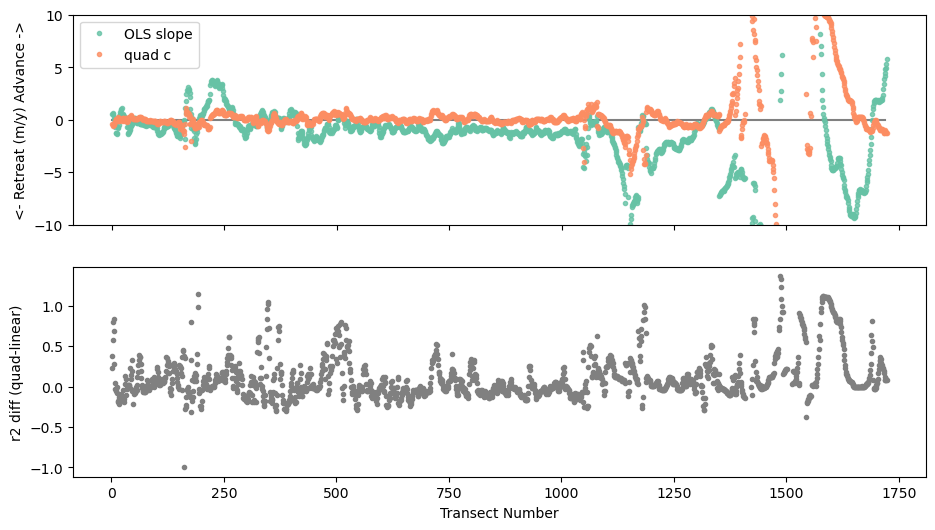

In [7]:
colors =['#66c2a5','#fc8d62','#8da0cb']
fig, (ax0, ax1) = plt.subplots(2, 1, figsize = (11,6) )
ax0.plot([0, 1720],[0,0],'-',c='gray')
ax0.plot(dft['transect'],dft['OLS slope'],'.', c=colors[0], alpha=.8, label='OLS slope')
ax0.plot(dft['transect'],10*dft['Quad c'],'.', c=colors[1], alpha=.8, label='quad c')
ax0.set_ylabel('<- Retreat (m/y) Advance ->')
ax0.set_ylim(-10, 10)
ax0.set_xticklabels([])
ax0.legend()
ax1.plot(dft['transect'],dft['r2adj quad']-dft['r2adj linear'],'.',c='gray')
ax1.set_xlabel('Transect Number')
ax1.set_ylabel('r2 diff (quad-linear)')
fig_name = fn.replace(".csv", "slopes_std.png")
plt.savefig(data_dir+fig_name, dpi=200, bbox_inches='tight')

OLS params:  [144.37632447  -2.77571552]
quad params:  [ 1.35404428e+02 -1.24949129e+00 -3.17272604e-02]
F-test p-value: 0.1495630688202947


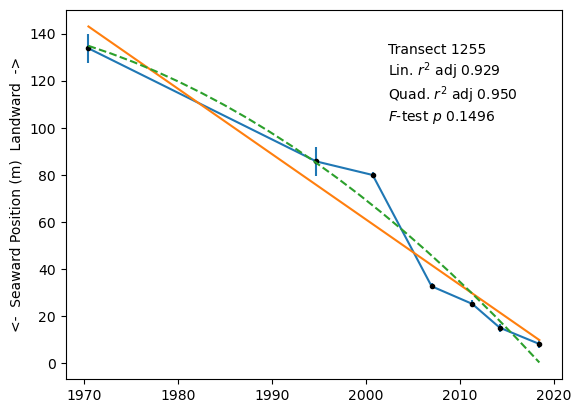

In [9]:
# plot one
transects = np.unique(df['TransectID'])

# Pre-filter the dataframe to keep only rows where decimal_year >= 1970
dff = df[df["decimal_year"] >= 1970]

tid = 1255
tdf = dff[dff["TransectID"] == tid].sort_values(by="decimal_year")

if len(tdf) >= 4:  # Ensure at least 4 valid rows
    x = tdf['decimal_year'].values - 1970
    y = tdf['Bias_Dista'].values
    yu = tdf['Bias_Uncer'].values

    n = len(x)
    yr_start = tdf['decimal_year'].values[0]  # First valid year
    yr_end   = tdf['decimal_year'].values[-1]  # Last year
    lon = tdf['IntersectX'].values[-1]  # Last latitude
    lat = tdf['IntersectY'].values[-1]  # Last longitude

    # Linear Fit
    X_linear = sm.add_constant(x)
    OLSfit = sm.OLS(y, X_linear).fit()
    print('OLS params: ',OLSfit.params)
    OLS_intercept, OLS_slope = OLSfit.params
    RSS_linear = np.sum(OLSfit.resid ** 2)
    RSS_linear_list.append( RSS_linear )
    
    # Quadratic Fit
    X_quadratic = np.column_stack((x, x**2))
    X_quadratic = sm.add_constant(X_quadratic)
    quad_model = sm.OLS(y, X_quadratic).fit()
    quad_params = quad_model.params
    print('quad params: ',quad_params)

    RSS_quad = np.sum(quad_model.resid ** 2)
    RSS_quad_list.append( RSS_quad )
    
    # AIC & Adjusted R^2
    n = len(x)
    AIC_linear = n * np.log(RSS_linear / n) + 2 * 2
    AIC_quad = n * np.log(RSS_quad / n) + 2 * 3
    AIC_linear_list.append( AIC_linear )
    AIC_quad_list.append( AIC_quad )
    
    r2adj_linear_list.append( OLSfit.rsquared_adj )
    r2adj_quad_list.append( quad_model.rsquared_adj )

    # F-test
    df1, df2 = 2, 3  # Model parameters (p1, p2)
    F = ((RSS_linear - RSS_quad) / (df2 - df1)) / (RSS_quad / (n - df2))
    p_value = 1 - stats.f.cdf(F, df2 - df1, n - df2)
    p_value_list.append( p_value )
    print("F-test p-value:", p_value)
    
    xhat = np.linspace( x[0], x[-1], 21 )
    yhat_lin = xhat*OLS_slope + OLS_intercept
    yhat_quad = quad_params[0] + xhat*quad_params[1] + xhat*xhat*quad_params[2]

    fig, ax = plt.subplots()
    plt.errorbar(x, y, yu, zorder=0)
    plt.plot(x, y, '.k', zorder=1 )
    plt.plot(xhat, yhat_lin,'-')
    plt.plot(xhat, yhat_quad, '--')

    xticks = [0, 10, 20, 30, 40, 50]
    xticklabels = ['1970','1980','1990','2000','2010','2020']
    ax.set_xticks( xticks )
    ax.set_xticklabels( xticklabels )
    plt.ylabel('<-  Seaward Position (m)  Landward  ->')
    ts = 'Transect {0}\nLin. $r^2$ adj {1:.3f}\nQuad. $r^2$ adj {2:.3f}\n$F$-test $p$ {3:.4f}'.format(tid, OLSfit.rsquared_adj, quad_model.rsquared_adj ,p_value)
    plt.text(.65, .7, ts, transform=ax.transAxes)

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(9, 9), sharex=True, sharey=True)

# First subplot
axs[0, 0].plot([-7, 7], [-7, 7], '--', c='gray')
sc1 = axs[0, 0].scatter(dft['OLS slope'], dft['TS slope'], s=12, c=dft['N'])
axs[0, 0].set_ylim(-10, 10)
axs[0, 0].set_xlim(-10, 10)
axs[0, 0].set_ylabel('TS Slope (m/y)')

# Second subplot
axs[1, 0].plot([-7, 7], [-7, 7], '--', c='gray')
sc2 = axs[1, 0].scatter(dft['OLS slope'], dft['WLS slope'], s=12, c=dft['N'])
axs[1, 0].set_ylim(-10, 10)
axs[1, 0].set_xlim(-10, 10)
axs[1, 0].set_ylabel('WLS Slope (m/y)')
axs[1, 0].set_xlabel('OLS Slope (m/y)')

# Third subplot (store handle for colorbar)
axs[0, 1].plot([-7, 7], [-7, 7], '--', c='gray')
im = axs[0, 1].scatter(dft['WLS slope'], dft['TS slope'], s=12, c=dft['N'])
axs[0, 1].set_ylim(-10, 10)
axs[0, 1].set_xlim(-10, 10)
axs[0, 1].set_xlabel('WLS Slope (m/y)')

# Turn off last subplot
axs[1, 1].set_axis_off()
# **Create a colorbar with controlled size**
cbar_ax = fig.add_axes([0.52, 0.11, 0.02, 0.35])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Number of Samples (N)')


fig_name = fn.replace(".csv", "slope_scatter.png")
plt.savefig(data_dir+'/plots/'+fig_name, dpi=200, bbox_inches='tight')

In [ ]:
from matplotlib.cm import ScalarMappable
fig, ax = plt.subplots(1, 1)
cmap = plt.get_cmap("Spectral")
slopes = dft['OLS slope']
norm = plt.Normalize(slopes.min(), slopes.max())
#norm = plt.Normalize(-1, 1 )
plt.scatter( dft['Longitude'], dft['Latitude'],s=4, c=dft['OLS slope'] )
sm =  ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.ax.set_title("scale")
fig_name = fn.replace(".csv", "slope_map.png")
plt.savefig(data_dir+'/plots/'+fig_name, dpi=200, bbox_inches='tight')

In [ ]:
# Get group names and define colors

colors =['#66c2a5','#fc8d62','#8da0cb']
bins = np.linspace( -5, 5, 100 )

ax = dft['OLS slope'].hist(figsize=(8, 4), edgecolor='gray', bins=bins, color=colors[0], alpha = .6, label = 'OLS' )
ax = dft['WLS slope'].hist(figsize=(8, 4), edgecolor='gray', bins=bins, color=colors[1], alpha = .6, label = 'WLS' )
ax = dft['TS slope'].hist(figsize=(8, 4), edgecolor='gray', bins=bins, color=colors[2], alpha = .6, label = 'TS')
plt.xlim(-6, 6)
plt.legend()

# Add a legend
#ax.legend(group_name)

# Add a title and axis label
ax.set_title('Distribution of Shoreline Change Rates')
ax.set_xlabel('<- Retreat (m/y) Advance ->')
ax.set_ylabel('Frequency')
fig_name = fn.replace(".csv", "slopes_hist.png")
plt.savefig(data_dir+'/plots/'+fig_name, dpi=200, bbox_inches='tight')

In [ ]:
# boxplots of slope distributions
slopes = [ dft['OLS slope'], dft['WLS slope'], dft['TS slope'] ]
labels = ['OLS', 'WLS', 'TS']
fig, ax = plt.subplots(figsize = (4, 5) )
ax.set_ylabel('Shoreline change (m/y)')

bplot = ax.boxplot(slopes, notch=True,
                   patch_artist=True,  # fill with color
                   tick_labels=labels)  # will be used to label x-ticks

# fill with colors
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
plt.ylim( -3, 3 )
plt.title('Slope Distribution by Fit Method')
fig_name = fn.replace(".csv", "slopes_box.png")
plt.savefig(data_dir+'/plots/'+fig_name, dpi=200, bbox_inches='tight')